# Análisis estacionalidad serie temporal

### Objetivo
Datos de ventas de propiedades para el período 2007-2019 en una región específica de estados unidos

### Data
https://www.kaggle.com/datasets/htagholdings/property-sales/data

### 0. Carga de librerías

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import boxcox

### 1. Carga de datos

In [2]:
# Añade el directorio raíz del proyecto al sys.path
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

from rfh_testdatascience_2.config import RAW_DATA_DIR

# Path al archivo
ts_path = RAW_DATA_DIR / "raw_sales.csv"

# Leer los datos
df_ts = pd.read_csv(ts_path, parse_dates=['datesold'])

2025-08-08 12:09:02.223 | INFO     | rfh_testdatascience_2.config:<module>:11 - PROJ_ROOT path is: C:\Users\Usuario\Desktop\Capgemini\RFH-TestDataScience-1\rfh_testdatascience_2


### 2. Revisión incial

In [3]:
# Mostrar primeras filas
print(df_ts.head())

    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3


In [4]:
df_ts.columns

Index(['datesold', 'postcode', 'price', 'propertyType', 'bedrooms'], dtype='object')

In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datesold      29580 non-null  datetime64[ns]
 1   postcode      29580 non-null  int64         
 2   price         29580 non-null  int64         
 3   propertyType  29580 non-null  object        
 4   bedrooms      29580 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


### 3. Análisis de variables

In [6]:
# postcode
df_ts['postcode'].value_counts()

postcode
2615    3566
2602    2603
2913    2558
2905    2259
2617    2115
2914    1972
2611    1864
2906    1640
2612    1210
2604    1058
2614    1058
2902    1035
2607     963
2904     919
2603     805
2605     771
2903     675
2606     659
2600     634
2912     499
2601     260
2911     249
2900     152
2620      26
2616      11
2609      10
2618       9
Name: count, dtype: int64

In [7]:
# propertyType
df_ts['propertyType'].value_counts()

propertyType
house    24552
unit      5028
Name: count, dtype: int64

In [8]:
# bedrooms
df_ts['bedrooms'].value_counts()

bedrooms
3    11933
4    10442
2     3598
5     1950
1     1627
0       30
Name: count, dtype: int64

In [9]:
df_ts['year'] = df_ts['datesold'].dt.year

In [10]:
# Agrupar por postcode, property_type y bedrooms
grouped = df_ts.groupby(['year', 'postcode', 'propertyType', 'bedrooms'])['price'].agg(['mean', 'median', 'count']).reset_index()
grouped.columns = ['year', 'postcode', 'propertyType', 'bedrooms', 'avg_price', 'median_price', 'num_sales']

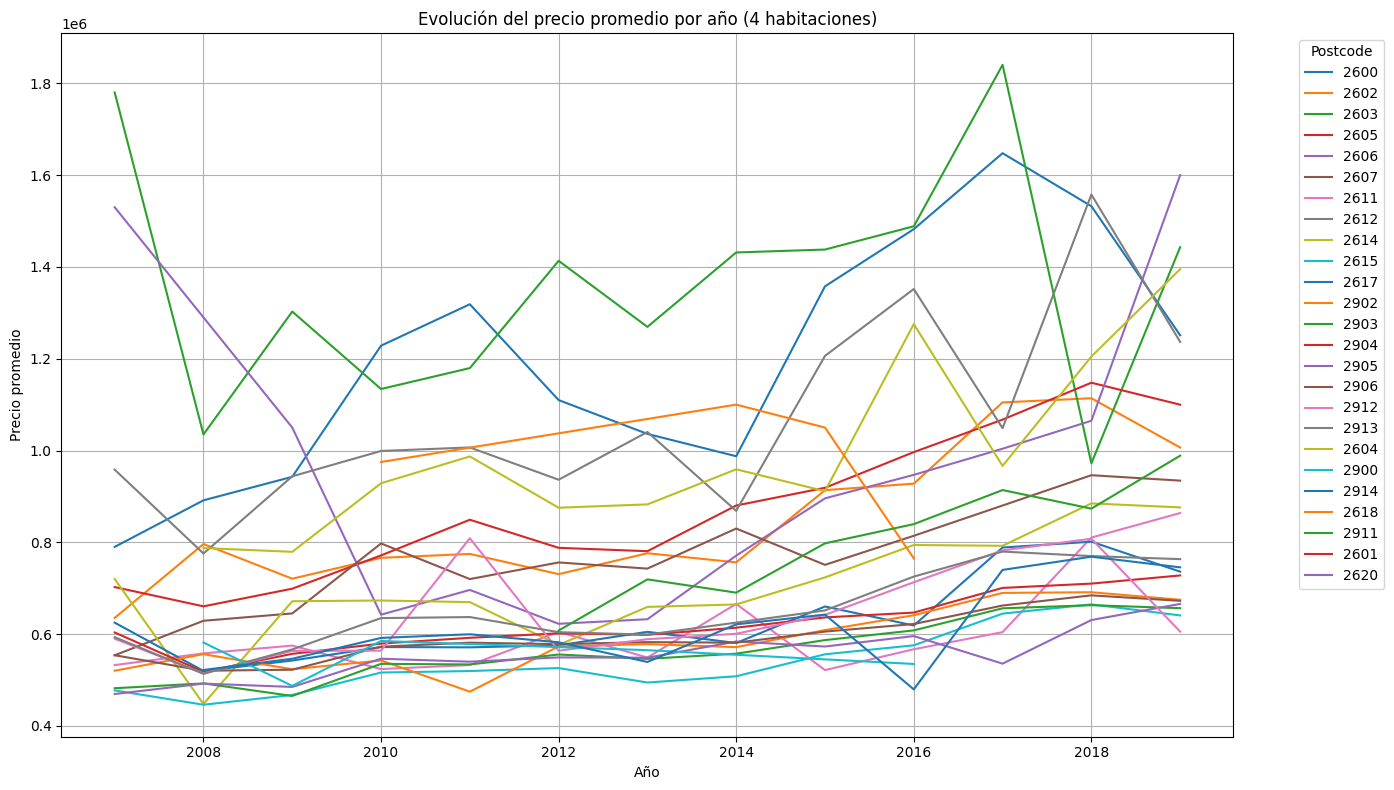

In [11]:
# con el objetivo de eliminar post code, graficamos para ver como evoluciona el precio en los diferentes postcode
df_4br = grouped[grouped['bedrooms'] == 4]
df_avg_price = df_4br.groupby(['year', 'postcode'])['avg_price'].mean().reset_index()

plt.figure(figsize=(14, 8))

# Opcional: seleccionar solo algunos postcodes si hay muchos
postcodes_to_plot = df_avg_price['postcode'].unique()

for pc in postcodes_to_plot:
    df_pc = df_avg_price[df_avg_price['postcode'] == pc]
    plt.plot(df_pc['year'], df_pc['avg_price'], label=str(pc))

plt.title('Evolución del precio promedio por año (4 habitaciones)')
plt.xlabel('Año')
plt.ylabel('Precio promedio')
plt.legend(title='Postcode', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.grid(True)
plt.show()

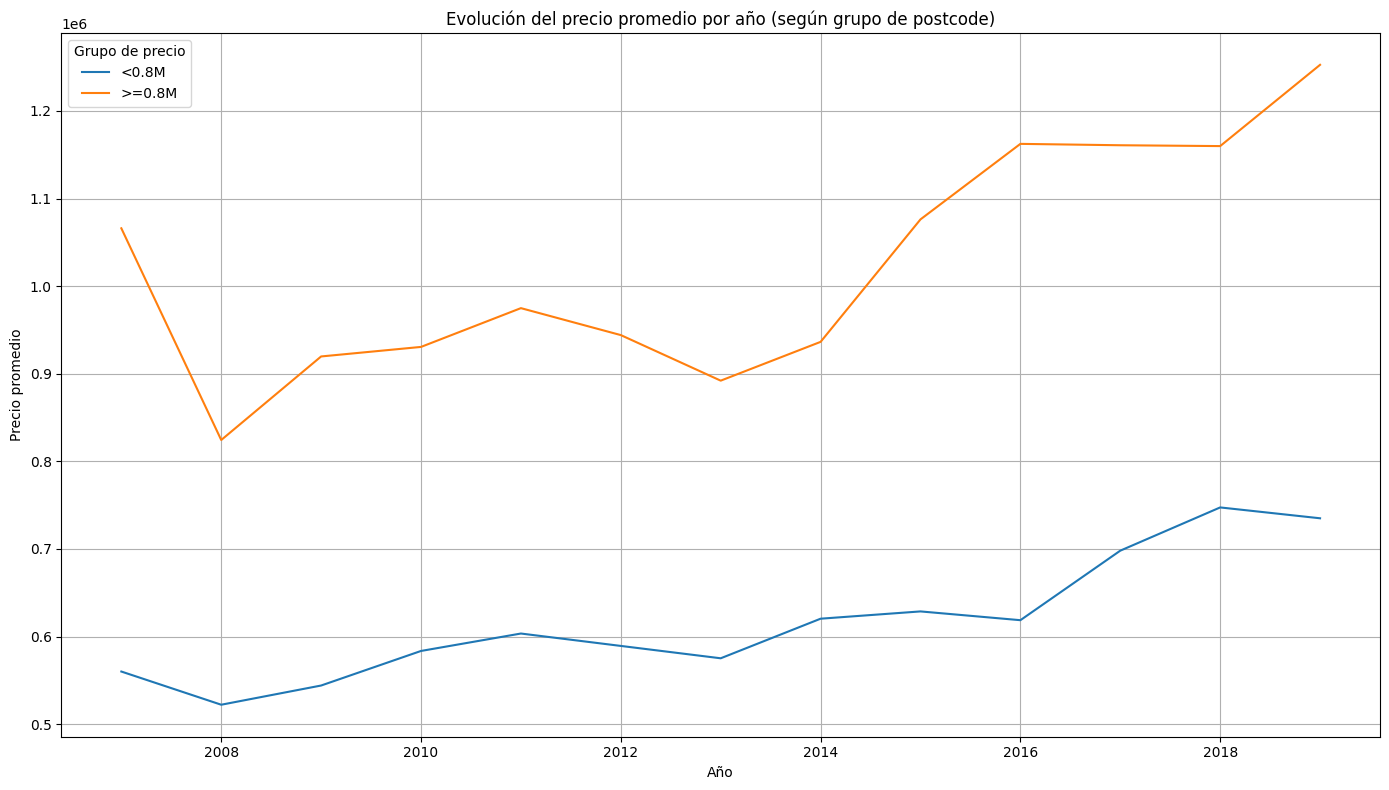

In [12]:
# Creamos dos grupos para price por encima de 0,8 y otro para price por debajo

# Precio promedio global por postcode (acumulado a través de los años)
postcode_avg = df_4br.groupby('postcode')['avg_price'].mean().reset_index()
postcode_avg.columns = ['postcode', 'overall_avg_price']

# Asignar grupo según el valor promedio
postcode_avg['price_group'] = postcode_avg['overall_avg_price'].apply(
    lambda x: '<0.8M' if x < 800000 else '>=0.8M'
)

# Unimos la columna 'price_group' al DataFrame original
df_4br = df_4br.merge(postcode_avg[['postcode', 'price_group']], on='postcode')

plt.figure(figsize=(14, 8))

# Agrupar por grupo y año, y promediar el avg_price
df_grouped_by_year = df_4br.groupby(['price_group', 'year'])['avg_price'].mean().reset_index()

# Graficar por grupo
for group in df_grouped_by_year['price_group'].unique():
    subset = df_grouped_by_year[df_grouped_by_year['price_group'] == group]
    plt.plot(subset['year'], subset['avg_price'], label=group)

plt.title('Evolución del precio promedio por año (según grupo de postcode)')
plt.xlabel('Año')
plt.ylabel('Precio promedio')
plt.legend(title='Grupo de precio')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
df_4br

,year,postcode,propertyType,bedrooms,avg_price,median_price,num_sales,price_group
0,2007,2600,house,4,7.900000e+05,790000.0,1,>=0.8M
1,2007,2602,house,4,6.353333e+05,506000.0,3,>=0.8M
2,2007,2603,house,4,1.780000e+06,1780000.0,1,>=0.8M
3,2007,2605,house,4,7.025000e+05,702500.0,2,>=0.8M
4,2007,2606,house,4,1.530000e+06,1530000.0,1,>=0.8M
...,...,...,...,...,...,...,...,...
304,2019,2906,house,4,6.725000e+05,655000.0,24,<0.8M
305,2019,2911,house,4,9.887625e+05,960050.0,8,>=0.8M
306,2019,2912,house,4,6.053750e+05,773750.0,4,<0.8M
307,2019,2913,house,4,7.633583e+05,760000.0,48,<0.8M


### Insight
- Se va a analizar el precio de las casas de 4 habitaciones en 2 series temporales diferentes >=0.8M y <0.8M

### 4. Creación data set

In [14]:
# Merge de la nueva columnas con el df_raw
postcode_avg = df_4br.groupby('postcode')['avg_price'].mean().reset_index()
postcode_avg.columns = ['postcode', 'overall_avg_price']

postcode_avg['price_group'] = postcode_avg['overall_avg_price'].apply(
    lambda x: '<0.8M' if x < 800000 else '>=0.8M'
)

In [15]:
postcode_avg

,postcode,overall_avg_price,price_group
0,2600,1.183104e+06,>=0.8M
1,2601,1.550000e+06,>=0.8M
2,2602,8.479321e+05,>=0.8M
3,2603,1.346898e+06,>=0.8M
4,2604,9.878427e+05,>=0.8M
5,2605,8.739736e+05,>=0.8M
6,2606,9.546609e+05,>=0.8M
7,2607,7.720760e+05,<0.8M
8,2611,5.898515e+05,<0.8M
9,2612,1.056439e+06,>=0.8M


In [16]:
df_ts = df_ts.merge(postcode_avg[['postcode', 'price_group']], on='postcode', how='left')

In [17]:
df_price_group_time = df_ts[df_ts['bedrooms']==4][['datesold', 'price_group', 'price']].copy()

In [18]:
df_price_group_time

,datesold,price_group,price
0,2007-02-07,<0.8M,525000
3,2007-03-09,<0.8M,380000
5,2007-04-04,<0.8M,465000
7,2007-04-30,>=0.8M,1530000
12,2007-06-27,>=0.8M,850000
...,...,...,...
28188,2017-12-13,>=0.8M,680000
28304,2018-02-05,<0.8M,535000
28424,2018-03-13,<0.8M,645000
28772,2018-07-04,>=0.8M,300000


In [19]:
# Agregar por meses
df_price_group_time['year_month'] = df_price_group_time['datesold'].dt.to_period('M')

In [20]:
monthly_avg = df_price_group_time.groupby(['year_month', 'price_group'])['price'].mean().reset_index()
monthly_avg.columns = ['year_month', 'price_group', 'avg_price']

In [21]:
monthly_avg

,year_month,price_group,avg_price
0,2007-02,<0.8M,5.250000e+05
1,2007-03,<0.8M,3.800000e+05
2,2007-04,<0.8M,4.650000e+05
3,2007-04,>=0.8M,1.530000e+06
4,2007-06,<0.8M,6.410000e+05
...,...,...,...
288,2019-05,>=0.8M,1.057300e+06
289,2019-06,<0.8M,7.635536e+05
290,2019-06,>=0.8M,9.896000e+05
291,2019-07,<0.8M,6.824758e+05


C:\Users\Usuario\AppData\Local\Temp\ipykernel_1764\2758723012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['year_month'] = subset['year_month'].astype(str)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_1764\2758723012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['year_month'] = subset['year_month'].astype(str)


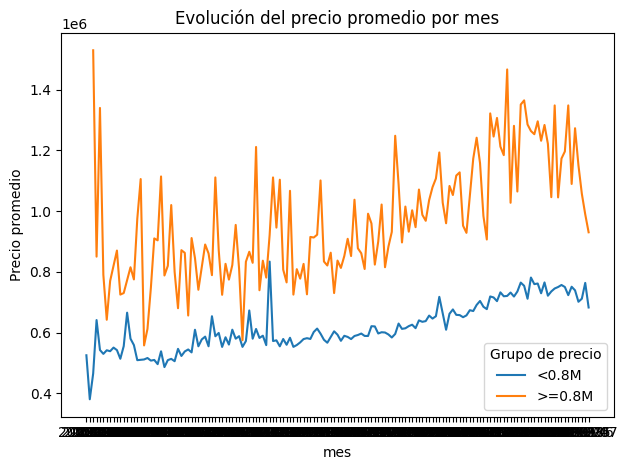

In [22]:
for group in monthly_avg['price_group'].unique():
    subset = monthly_avg[monthly_avg['price_group'] == group]
    subset['year_month'] = subset['year_month'].astype(str)
    plt.plot(subset['year_month'], subset['avg_price'], label=group)

plt.title('Evolución del precio promedio por mes')
plt.xlabel('mes')
plt.ylabel('Precio promedio')
plt.legend(title='Grupo de precio')
plt.tight_layout()
plt.show()

### 5. Analisis serie estacionaría

In [23]:
def test_stationarity(series, alpha=0.05):
    """
    Evalúa si una serie temporal es estacionaria usando ADF
    
    Parámetros:
    - series: pandas Series con la serie temporal
    - alpha: nivel de significancia (por defecto 0.05)
    
    Retorna:
    - Diccionario con resultados ADF
    """
    series = series.dropna()

    # --- ADF Test ---
    adf_result = adfuller(series, autolag='AIC')
    adf_pvalue = adf_result[1]
    adf_stationary = adf_pvalue <= alpha

    return {
        "ADF p-value": adf_pvalue,
        "ADF Stationary?": adf_stationary,
    }

In [24]:
for group in monthly_avg['price_group'].unique():
    subset = monthly_avg[monthly_avg['price_group'] == group]
    print(f'---------{group}---------')
    results = test_stationarity(subset['avg_price'])
    print(results)

---------<0.8M---------
{'ADF p-value': np.float64(0.8399960404952054), 'ADF Stationary?': np.False_}
--------->=0.8M---------
{'ADF p-value': np.float64(0.8327284762435663), 'ADF Stationary?': np.False_}


#### Insights
- Es claramente no estacionaria ya que el p-valor esta cercano a 1.

### 6. Convirtiendo la serie en estacionaria

In [27]:
# Ejemplo para un grupo específico
df_low = monthly_avg[monthly_avg['price_group'] == '<0.8M'].set_index('year_month')
df_high = monthly_avg[monthly_avg['price_group'] == '>=0.8M'].set_index('year_month')

# Diferenciación de primer orden
df_low_diff = df_low['avg_price'].diff().dropna()
df_high_diff = df_high['avg_price'].diff().dropna()

In [30]:
print("---- <0.8M ----")
print(test_stationarity(df_low_diff))

print("---- >=0.8M ----")
print(test_stationarity(df_high_diff))

---- <0.8M ----
{'ADF p-value': np.float64(2.035786282668992e-16), 'ADF Stationary?': np.True_}
---- >=0.8M ----
{'ADF p-value': np.float64(1.170117712018349e-06), 'ADF Stationary?': np.True_}


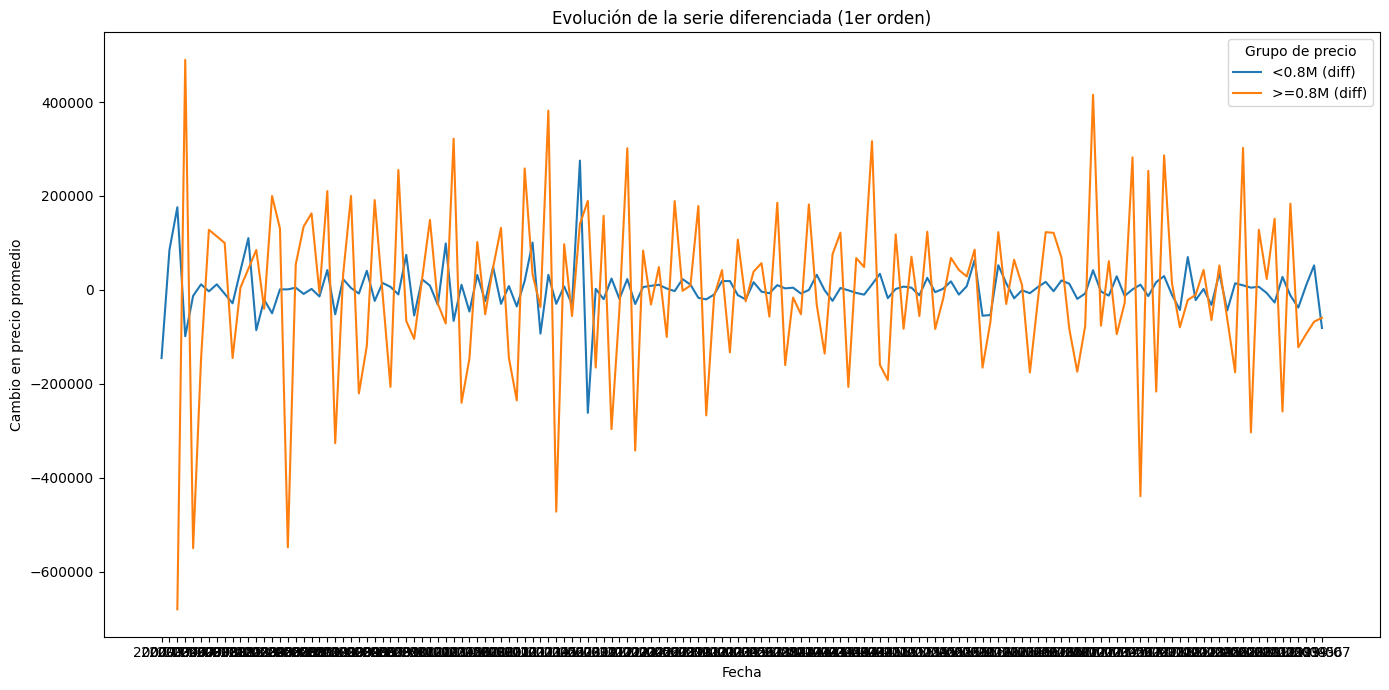

In [34]:
plt.figure(figsize=(14, 7))

for group in monthly_avg['price_group'].unique():
    # Filtrar grupo y ordenar por fecha
    subset = monthly_avg[monthly_avg['price_group'] == group].sort_values('year_month')
    subset['year_month'] = subset['year_month'].astype(str)
    subset = subset.set_index('year_month')
    
    # Diferenciación de primer orden
    subset_diff = subset['avg_price'].diff().dropna()

    # Graficar
    plt.plot(subset_diff.index, subset_diff.values, label=f"{group} (diff)")

plt.title('Evolución de la serie diferenciada (1er orden)')
plt.xlabel('Fecha')
plt.ylabel('Cambio en precio promedio')
plt.legend(title='Grupo de precio')
plt.tight_layout()
plt.show()

#### Insights
- Con una diferenciación la serie ahora es estacionaria